In [47]:
import time

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from numpy import concatenate
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
# from keras.layers.normalization import BatchNormalization
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [49]:
n_in = 1  #历史数量
n_out = 1 #预测数量
n_features = 1
# n_test = 1
n_val = 1
n_epochs = 100
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

In [57]:
#导入数据
def load_stw_data() -> pd.DataFrame:
    rawdata = pd.read_csv('data/groupByCZ/test.csv')
    rawdata = rawdata.drop(columns='cz')
    # rawdata = rawdata.drop(columns='tm')
    rawdata = rawdata.loc[:, ~rawdata.columns.str.contains('^Unnamed')]
    # rawdata.columns = ['i', 'pp']
    rawdata.columns = ['pp', 'tm']
    rawdata.pp = rawdata.pp.astype("float32")
    # rawdata.i = rawdata.i.astype(int)
    # rawdata = pd.read_csv('data/groupByCZ/test.csv')
    # rawdata = rawdata.drop(columns='cz')
    return rawdata

In [51]:
#MinMaxScaler数据归一化，可以帮助网络模型更快的拟合，稍微有一些提高准确率的效果
def minmaxscaler(data: pd.DataFrame) -> pd.DataFrame:
    data = data.drop(columns='tm')
    pp = data['pp'].values
    pp = pp.reshape(len(pp), 1)
    pp = scaler.fit_transform(pp)
    pp = pp.reshape(len(pp), )
    data['pp'] = pp

    return data

In [52]:
#划分训练数据集和验证数据集,这里需要注意的是我么需要预测的数据是不可以出现在训练中的，切记。
def split_data(x, y, n_test: int):
    x_train = x[:-n_val - n_out + 1]
    x_val = x[-n_val:]
    y_train = y[:-n_val - n_out + 1]
    y_val = y[-n_val:]
    return x_train, y_train, x_val, y_val

In [53]:
#划分X和Y
def build_train(train, n_in, n_out):
    X_train, Y_train = [], []
    for i in range(train.shape[0] - n_in - n_out + 1):
        X_train.append(np.array(train.iloc[i:i + n_in]))
        Y_train.append(np.array(train.iloc[i + n_in:i + n_in + n_out]["pp"]))

    return np.array(X_train), np.array(Y_train)

In [54]:
# class MyLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(MyLSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True).to(device)
#         self.fc = nn.Linear(hidden_size, output_size).to(device)
#
#     def forward(self, input_data):
#         h0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).requires_grad_().cuda()
#         c0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).requires_grad_().cuda()
#         output, (hn, cn) = self.lstm(input_data, (h0.detach(), c0.detach()))
#         output = self.fc(output[:, -1, :])
#         return output

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_data):
        h0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).requires_grad_()
        output, (hn, cn) = self.lstm(input_data, (h0.detach(), c0.detach()))
        output = self.fc(output[:, -1, :])
        return output

# def build_lstm(n_in: int, n_features: int, data: pd.DataFrame):
# 定义常量
# bs, T, i_size, h_size = 2, data.shape[0], data.shape[1], 10  #batch_size  Time  input_size hidden_size
# proj_size = 3  #投影大小
# data = np.array(data)
# data = torch.tensor(data, dtype=torch.float)
# input = data  # (T, bs, i_size)
# print(i_size)
# print(input.shape)
# c0 = torch.randn(bs, h_size)  # 初始值 不参与训练
# h0 = torch.randn(bs, h_size)  # 初始值 不参与训练
#

# lstm_layer = nn.LSTM(i_size, h_size, 2, batch_first=True)  # (i_size h_size num_layer)
# output, (h_n, c_n) = lstm_layer(input, (h0, c0))
# print(output)  # (T, bs, h_size * direction)
i_size = 1
h_size = 16
num_layer = 2
o_size = 1

model = MyLSTM(input_size=i_size, hidden_size=h_size, num_layers=num_layer, output_size=o_size)
# model = nn.LSTM(input_size=i_size, hidden_size=h_size, num_layers=num_layer).to(device)

criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

        pp
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
...    ...
15951  0.0
15952  0.0
15953  0.0
15954  0.0
15955  0.0

[15956 rows x 1 columns]


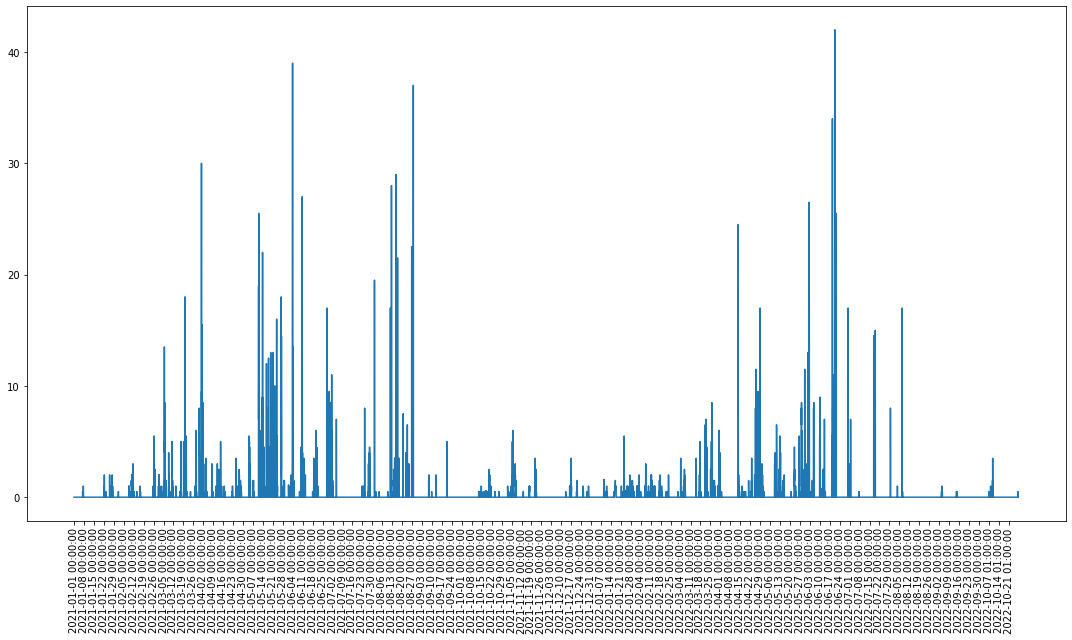

In [55]:
data = load_stw_data()
# print(data)
plt.figure(figsize=(15, 9))
plt.plot(data['pp'])
plt.xticks(range(0, data.shape[0], 168), data['tm'].loc[::168], rotation=90)
plt.tight_layout()
plt.savefig('data/img/test.jpg')
# plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
data = minmaxscaler(data)
print(data)
data_copy = data.copy()
# print(data_copy.shape)
x, y = build_train(data_copy, n_in, n_out)
# print(x.shape)
x_train, y_train, x_val, y_val = split_data(x, y, n_val)
# x_train = torch.Tensor(x_train).float().cuda()
# y_train = torch.Tensor(y_train).float().cuda()
# x_val = torch.Tensor(x_val).float().cuda()
# y_val = torch.Tensor(y_val).float().cuda()
x_train = torch.Tensor(x_train).float()
y_train = torch.Tensor(y_train).float()
x_val = torch.Tensor(x_val).float()
y_val = torch.Tensor(y_val).float()
# model = model_fit(x_train, y_train, x_val, y_val, 1)

In [39]:
hist = np.zeros(n_epochs)
start_time = time.time()
lstm = []
for t in range(n_epochs):
    prediction = model(x_train)
    # fc = nn.Linear(h_size, o_size).to(device)
    # print(prediction[0].shape)
    # output = fc(prediction[0][:, -1, :])
    # print(output.shape, y_train.shape, sep=' ')
    loss = criterion(prediction, y_train)
    print(f"Epoch:{t} MSE:{loss.item()}")
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

print(f"Training Time:{time.time() - start_time}")

C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([15765, 12])) that is different to the input size (torch.Size([15765, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:0 MSE:0.010797829367220402
Epoch:1 MSE:0.0012631772551685572
Epoch:2 MSE:0.0039624120108783245
Epoch:3 MSE:0.004861948546022177
Epoch:4 MSE:0.003259371966123581
Epoch:5 MSE:0.0017440466908738017
Epoch:6 MSE:0.0011960809351876378
Epoch:7 MSE:0.0014650198863819242
Epoch:8 MSE:0.0019627383444458246
Epoch:9 MSE:0.002183553297072649
Epoch:10 MSE:0.0020398530177772045
Epoch:11 MSE:0.0017088608583435416
Epoch:12 MSE:0.0013959889765828848
Epoch:13 MSE:0.0012203700607642531
Epoch:14 MSE:0.0012012544320896268
Epoch:15 MSE:0.0012894815299659967
Epoch:16 MSE:0.0014094357611611485
Epoch:17 MSE:0.0014952364144846797
Epoch:18 MSE:0.0015125299105420709
Epoch:19 MSE:0.001462724874727428
Epoch:20 MSE:0.001373069710098207
Epoch:21 MSE:0.0012801791308447719
Epoch:22 MSE:0.0012145863147452474
Epoch:23 MSE:0.0011910964967682958
Epoch:24 MSE:0.00120660406537354
Epoch:25 MSE:0.0012445506872609258
Epoch:26 MSE:0.0012834032531827688
Epoch:27 MSE:0.001305535901337862
Epoch:28 MSE:0.001303137862123549
Epoch

In [56]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

torch.Size([15954, 1, 1])
torch.Size([1, 1, 1])
torch.Size([15954, 1])
torch.Size([1, 1])


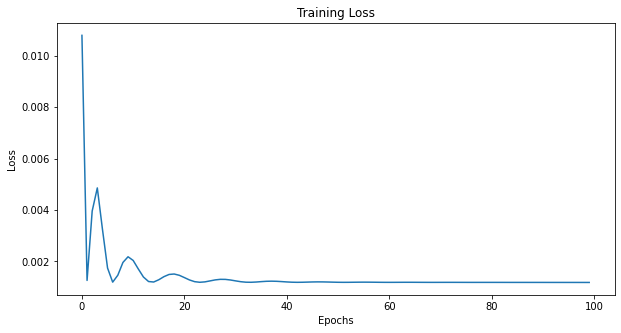

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(range(hist.size), hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [48]:
predict = model(x_val)
x_val = x_val.reshape((x_val.shape[0], x_val.shape[2]))
predict_inv = concatenate((predict, x_val[:, 1:]), axis=1)
predict_inv = scaler.inverse_transform(predict_inv)
predict_inv = predict_inv[:, 0]

original_inv = scaler.inverse_transform(x_val)
original_inv = original_inv[:, 0]
print(predict_inv)
print(original_inv)
# plt.figure(figsize=(15, 9))
# # plt.plot(orig.index, orig[0])
# # plt.plot(validation.index, data['pp'][-validation.shape[0]:])
# plt.plot(validation, validation[0])
# plt.show()

RuntimeError: shape '[1, 1]' is invalid for input of size 168